# Transect Cutting

This jupyter notebook can be used to help slice csv data files. You should be
using the `sync_data` for this, ideally calibrated but that is not particularly
important as the calibration factor is far smaller than the uncertainty of the
model.

Note this is intended to be used for methane transects, but can be modified for
other gasses.

## Usage

On the first run after restarting the kernel, you need to execute Group 2, or
the first two cells. This loads all necessary packages and sets up for slicing
the transects. Next, you will need to choose the source data file that you want
to cut transects from. Assign the path of the csv file to `data_file_path` in
the third cell and execute it. Finally you may begin cutting transects by
executing Group 1. 

Here is the general workflow for cutting transects:
1. On the first run and each time after restarting the kernel, you need to
execute Group 2, or the first two cells. This loads all necessary packages and
sets up for slicing the transects.
2. Next, you will need to choose the source data file that you want
to cut transects from. Assign the path of the csv file to `data_file_path` in
the third cell and execute it.
    * See [here](#selecting-data-files) for more help on how to find data for a
      specific site. 
3. In the third cell, set the coordinate of the source/site you wish cut
   transects for. This should be in the form (lat, lon) in degrees.
4. Change `start_time` and `end_time` to the correct values and execute Group 1,
   or manually run the next 3 cells. Two plots should now appear. Use these as
   reference to adjust the start and times as necessary. Repeat until you have
   your desired transect.
5. Run the final cell in this file. It will now save your cut transect in the
   `results` folder. There is a built in functionality to increment a counter
   that is appended to the end of the file name to prevent overwriting a saved
   file. This counter is reset whenever a new data file is chosen and the third
   cell is run. 



## TODO: Selecting Data Files (WIP)

In [14]:
import numpy as np
import pandas as pd
import regex as re
import os
from coord_convert import *
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

In [15]:
# set plot color parameters
v = [
    0,
    0.01,
    0.05,
    0.10,
    0.5,
    1.0,
    5.0,
    10.0,
    15.0,
    25.0,
    50.0,
    100.0,
    500.0,
    1000.0,
    5000.0,
    10000.0,
]
col = [
    "aqua",
    "LightBlue",
    "SlateBlue",
    "blue",
    "darkblue",
    "forestgreen",
    "SeaGreen",
    "palegreen",
    "lemonchiffon",
    "yellow",
    "gold",
    "orange",
    "red",
    "darkred",
    "black",
]

In [742]:
##########################
# Change Parameters Here #
##########################
data_file_path = "Data/sync_data_calibrated_2023-11-08.csv"
# source_coordinates = convert_coord(42.974019, -81.872951) # TwinCreeks
# source_coordinates = convert_coord(42.716203, -82.221792) # Dawn
source_coordinates = convert_coord( 42.761882, -82.453059) # Courtright
site = "Courtright"


df = pd.read_csv(data_file_path)
df["gps_time"] = pd.to_datetime(df["gps_time"])
i = 1

In [833]:
# cut transect by time
start_time = np.datetime64("2023-11-08 21:15:00")
end_time = np.datetime64("2023-11-08 21:16:40")

df_cut = df[(df["gps_time"] > start_time) & (df["gps_time"] < end_time)]
print(len(df_cut))
assert len(df_cut)

100


In [834]:
# prep data for plotting
x, y = convert_coord(df_cut["lat"], df_cut["lon"])
temp = np.mean(df_cut["temp"])
pressure = np.mean(df_cut["pressure"])
ch4 = np.array(df_cut["ch4d"], copy=True)
ch4 *= 1000 # ppm to ppb
Vm = 22.414 * 1013.25 / pressure * (temp + 273.15) / 273.15
factor = Vm / 16.04
ch4 *= factor
bckgd = stats.scoreatpercentile(ch4, 5)

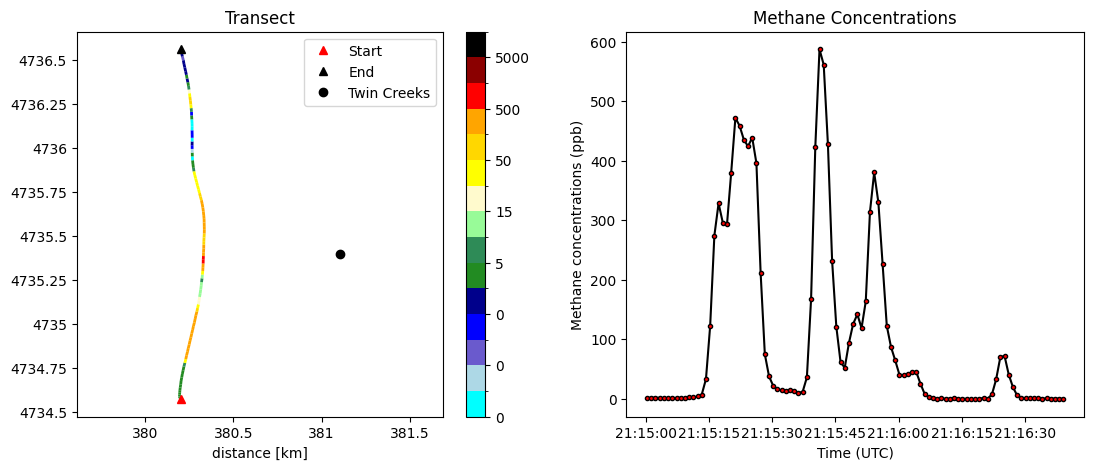

In [835]:
# Color segment plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
# # shift origin
# x -= x.min()
# y -= y.min()
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
cmap = ListedColormap(col)
norm = BoundaryNorm(v, cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.array(ch4) - bckgd)
lc.set_linewidth(2)
line = ax1.add_collection(lc)
cbar = fig.colorbar(line, ax=ax1)
# cbar.set_label("Methane concentrations (ppb)")
ax1.plot(x, y, linewidth=0)
ax1.plot(x.iloc[0], y.iloc[0], 'r^', label="Start")
ax1.plot(x.iloc[-1], y.iloc[-1], 'k^', label="End")
ax1.plot(*source_coordinates, 'ko', label='Twin Creeks')
# Rescale axis
scale_x = 1e3
scale_y = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_xlabel("distance [km]")
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)
ax1.axis("equal")
ax1.legend()
ax1.set_title("Transect")
ax2.plot(df_cut["gps_time"], ch4-bckgd, 'k.-', mfc='r', label="Measurements")
ax2.set_title("Methane Concentrations")
ax2.set_ylabel("Methane concentrations (ppb)")
ax2.set_xlabel("Time (UTC)")
plt.show()

In [836]:
date = re.findall("(?<=_)\d{2,4}-\d{2}-\d{2}", data_file_path)[0]
folder = os.path.join("transects", site, date)
if not os.path.exists(folder):
    os.makedirs(folder)
df_cut.to_csv(os.path.join(folder, f"{date}_{i}.csv"))
i += 1